In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
from tqdm import tqdm
from copy import deepcopy
import seaborn as sns
try:
    import plotly.graph_objects as go
except:
    !pip install plotly # Or install the plotly library manually
    import plotly.graph_objects as go    

# required only for jupyter notebooks / while running on colab
%matplotlib inline 

# set seed
seed = 1
np.random.seed(seed)

# Part I - Data pre-processing + linear regression

## Standardization

Standardizing the data is a good practice. Standardization is a scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation. Standardizing features helps us in training the model faster.

The formula for standardizing the data is given below:

# $X′= \frac{X−μ}{σ}\hspace{4cm}-(a)$ 

where

μ : mean of the attribute

σ : standard deviation of the attribute

Numpy provides functions to implement the above

For additional information refer [this](https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff).

Note: You do not need to standardize Y

In [ ]:
def standardize(X):
    """
    Args:
        'X': numpy ndarray 
    Returns:
        'X_norm': normalized X also in numpy ndarray format
    """
    X_norm = (X - X.mean(axis=0))/(X.std(axis=0))
    return X_norm 

## Initialize parameters [0.25 marks]

As uncomplicated it may seem, initializing your weights play an important role in overall performance of your model. If initial wts. are too small/large then it may lead to problem of vanishing/emploding gradients respectively.

For introductory purpose, we will be taking weights from Gaussian Distribution. But there are has been tremendous research in this area, and Xavier Initialization has proved to be very effective for multiple tasks. There are in-built methods for Xavier initialization in frameworks like tensorflow, pytorch, caffe. To understand the maths behind Xavier Initialization, refer to the article attached below!

Refer to this article to understand the importance of effective initialization. [deeplearning.ai/notes](https://www.deeplearning.ai/ai-notes/initialization/#IV)

For our model we will be initialising Weights as an array or random integers and bias as array of zeroes. You can take help of formula $(i)$ from the next section's theory i.e. forward to know the relation between the dimensions of W and b with respect to X and Y. 

### 
Initialise weights with the shape given in function below having values **between 0 and 1** using numpy.random.rand function.

> Initialise bias with the shape given below as a numpy array having all zeros.

In [ ]:
def initialize_parameters(X, Y):
    """
    Args:
    'Y': ndarray of shape (m,output_size)
    'X': ndarray of shape (m, no. of features)
    Returns:
    'W', 'b': Wts. and biases
    'W' : ndarray of shape(no. of features, output_size)
    'b' : ndarray of shape(1, output_size)
    
    output_size = 1 since we are only predicting median_house_value. 
    IF we predicting say house price and no of people that can stay in it, then we would require output_size = 2 and so on.
    """
    W = np.random.rand(X.shape[1], Y.shape[1])
    b = np.zeros([1, Y.shape[1]])
    return W, b;

## Forward

This is the function where actual calculation of the prediction values happen with the help of weights and bias.

For two varaibles it is a straight line of form $y = mx + c$ there m and c are slope and intercepts of line respectively but for more than one variables since each variable contributes to the output value the equation becomes a dot product of weights with the variables. Where each weight ($w_i$) represent the propotionality factor of prediction values with respect to the corresponding variable ($x_i$). $b$ is refered as bias which is analogus to the intercept value in case of two variables. 

# $ \boxed{Y_{pred} = w_1 x_1 + w_2 x_2 + .... + w_i x_i + b}\hspace{4cm} -(i)$

or 

# $ Y_{pred} = X \cdot W + b$

In [ ]:
def forward(X, W, b):
    """
    Args:
    'X': ndarray of shape (m,no.of features)
    'W': ndarray of shape (no. of features, output_size)
    'b': ndarray of shape (1, output_size) 
    Returns:
    calculated Y_pred value using X,W and b
    """
    Y_pred = np.matmul([X], W) + b
    return Y_pred

## Loss

A loss function is a measure of how good a prediction model does in terms of being able to predict the expected outcome. There is not a single loss function that works for all kind of data. It depends on a number of factors including the presence of outliers, choice of machine learning algorithm, time efficiency of gradient descent, ease of finding the derivatives and confidence of predictions.

For our dataset, we have chosen Mean Square Error because of its ease of implementation and competitive performance with other loss functions. 

# $ MSE = \frac{\sum_{i = 1}^{m} ({Y^{pred}_i - Y^{true}_i})^2}{2m}$

here $Y^{pred}_i$ is the $i^{th}$ prediction value corresponding to $i^{th}$  $Y^{true}_i$ (actual)value. 
$m$ is the number of actual values 

In [ ]:
def loss(y_pred, y_true):
    """
    Args:
    'y_pred': ndarray of shape (m,1) storing output predictions
    'y_true': ndarray of shape (m,1) storing true house prices
    Returns:
    'mse': mean square error
    """
    mse = (np.sum((y_pred - y_true)*(y_pred - y_true)))/(2*y_pred.shape[0])
    return mse

## Gradients [0.5 marks]

In order to optimise our model and increase it's accuracy we will use a technique called **Stochastic Gradient Decent**(SGD). As per wikipedia Stochastic gradient descent is an iterative method for optimizing an objective function with suitable smoothness properties. From this we understand that we would be minimising the error between our prediction values and actual values. 
But before that we need to calculate our prediction values using the same formula as in the forward function. 

Now after getting certain value of loss in our first prediction we would change our weights and bias in a manner that our loss reduces. 

# $W_j = W_{j-1} - \frac{\partial L(Y_p)}{\partial W}$

where $W_j$ stands for weight at $j^{th}$ iteration and $\frac{\partial L(Y_p)}{\partial W}$ stands for partial derivative of Loss function with respect to weights. Above formula upon partial differentiation simplifies to

# $\boxed{W_j = W_{j-1} - \alpha * dW }     \hspace{3cm}    -(ii)$

where $\alpha$ is a constant called **learning rate** and dW is the partial derivative part given by the following formula

# $ dW = \frac{\partial L(Y_p)}{\partial Y}\frac{\partial Y}{\partial W} = \frac{2((WX + b) - Y_t)}{2m}* (X)  $

or:

# $ dW = \frac{\partial L(Y_p)}{\partial W} =  \frac{X^T*(Y_p - Y_t)}{m}  $

The $ {X^T} $ implies Transpose of  $ X $ (Just try to matrix multiply $ X $ directly with  $ (Y_p - Y_t) $ and you'll understand why we need to use transpose of X in multiplication)

<br/>
Similar analysis can be done for bias(b)

# $b_j = b_{j-1} - \frac{\partial L(Y_p)}{\partial b}$

which can also be written as 

# $\boxed{b_j = b_{j-1} - \alpha * db }      \hspace{3cm}    -(iii)$

# $ db = \frac{\partial L(Y_p)}{\partial b} =  \sum\frac{(Y_p - Y_t)}{m}  $

$dW$ and $db$ are together refered as gradients 

In [ ]:
def grads(X, y_pred, y_true):
    """
    Args:
    'X': The input matrix 
    'y_pred': ndarray of shape (m,1) storing output predictions
    'y_true': ndarray of shape (m,1) storing true house prices
    Returns:
    'dW': gradients of weights
    'db': gradient of biases 
    """
    dW = np.matmul([X.T], y_pred - y_true)/(y_pred.shape[0])
    db = np.sum(y_pred - y_true)/(y_pred.shape[0])
    return dW, db

## Stochastic Gradient Decent

After calculating gradients of weights and bias, we will now do the changes in their respective values with the help of expressions $(ii)$ and $(iii)$ discussed above. 
Learning Rate ($\alpha$) gives the measure of The amount that the weights are updated during training. Its value lies between 0.0 and 1.0. 

The weights are now updated via the learning rules:

$$ W = W - \alpha \text{ } dW $$
$$ b = b - \alpha \text{ } db $$

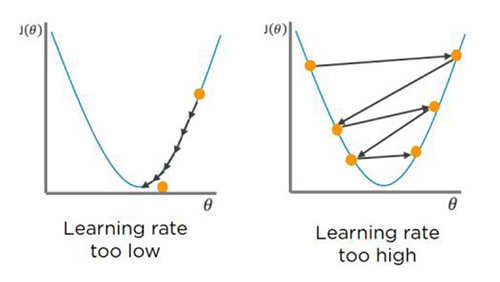

In the above two graphs we see the effect of high learning rates and effect of low learning rates. Each arrow depicts the change in the value at each subsequent step. A higher learning rate might saturate fast towards the local minimum where as the low learning rate takes much more iterations. But high learning rate might also start moving away from the local minimum hence increasing the loss. 


In [ ]:
def sgd(W, b, grads, alpha):
    """
    Args:
    'W' : (n, output_size) array
    'b' : (1,output_size)
    'grads': list of dW, db
    'alpha': learning rate
    Return:
    Updated parameters
    updated_w : updated value of 'W' using the formula given above 
    updated_b : updated value of 'b' using the formula given above
    """
    updated_w = W - alpha * grads[0]
    updated_b = b - alpha * grads[1]
    return updated_w, updated_b

## Build Model

Congratulations! Now we have all the helper functions required to build our model. In this final function, we will call above functions in a systematic way and let our model train on given dataset. Follow the instructions carefully.

### Steps to follow for building the model
The following operations need to be performed in the function "model" below:
<br/>
<br/>
1) Standardize X and Y which are input to the model (Note that X and Y are currently NOT standardized)

2) Ensure shape of X is (m,no.of features) where m is the number of data points and no. of features is 8

3) Initialise the parameters W and b using the STANDARDIZED X and Y with the help of the function *initialize_parameters*

4) For N number of iterations :

    - Calculate y_predicted by performing a forward pass(No need to standardize this y_predicted)
    
    - Find out the loss using y_predicted and y_true 
    
    - Append the current loss to a list of all losses so that we can return it and plot it
    
    - Calculate the Gradients
    
    - Update W and b using SGD
    
    - Now use these updated W and b to perform a forward pass in the next iteration and again compute loss, gradients,sgd and so on
    

In [ ]:
def model(X , Y, iterations=1500, learning_rate=0.009):
    """
    Args:
    'X': ndarray of shape (m,no. of features) which is NOT Standardized
    'Y': ndarray of shape (m,1) which is NOT Standardized
    'iterations': iterations for training our data
    Returns:
    y_pred: predicted value of output
    y_true: true value of output (The 'Y' argument after standardization gives y_true)
    losses: for grading purpose
    W , b : The final TRAINED weights and biases of the model
    Return in the following order : [y_pred , y_true, losses , W , b]
    """
    X_standardized = standardize(X)
    Y_standardized = standardize(Y)
    initial_W, initial_b = initialize_parameters(X_standardized, Y_standardized)
    losses = []
    W, b = initial_W, initial_b
    for i in range(0, iterations):
        Y_pred = forward(X_standardized, W, b)
        Y_pred = Y_pred.reshape(X_standardized.shape[0], 1)
        mse_loss = loss(Y_pred, Y_standardized)
        losses.append(mse_loss)
        dW, db = grads(X_standardized, Y_pred, Y_standardized)
        updated_W, updated_b = sgd(W, b, [dW, db], learning_rate)
        W, b = updated_W, updated_b
    plt.plot(losses)
    return [Y_pred, Y_standardized, losses, W, b]

In [ ]:
df =  pd.read_csv('housing_data.csv')
df.dropna(axis=1,inplace=True)
X = df.iloc[:,:8] 
Y = np.array(df['median_house_value'])
Y = Y.reshape(Y.shape[0],1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250


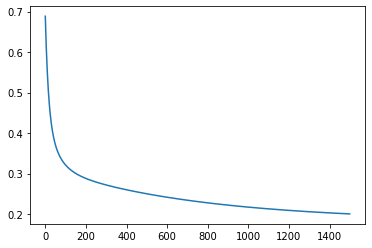

In [ ]:
np.random.seed(1)
y_pred , y_true, losses , trained_w , trained_b = model(X, Y)

In [ ]:
mean_squared_error(y_pred,y_true)

0.40114597686104614

The MSE of linear model is around 0.38 - 0.42 on a scale of 0 - 1.   
In the next section we will compare this score with the MSE obtained by using a Neural Network for the same task.

In [ ]:
df_test  = pd.read_csv('california_housing_test.csv')
scaler = MinMaxScaler()
scaler.fit(df)
test_scaled_data = scaler.transform(df_test)
test_scaled_df = pd.DataFrame(test_scaled_data,columns=df_test.columns) #make sure column names are retained

xtest = test_scaled_df.iloc[:,0:8] 
ytest = test_scaled_df.iloc[:,8:9]
xtest  = xtest.values
ytest = ytest.values.reshape(-1,1)

ytest_pred = forward(xtest,trained_w,trained_b)
ytest_pred = ytest_pred.reshape(xtest.shape[0],1)
print(mean_squared_error(ytest,ytest_pred))

0.10641728205461223


## Visualization of work done so far

Visualisation of data is an important technique which can be used to see the results discretly and at the same time make suitable comparisions with the test cases to check how the model is working. Here we try to plot predicted values and actual values together in one graph with median_income as the independent variable. We also plot a correlation heat map to find out that our dependent variable depends on which factors majorly. 



In [ ]:
#making copies of data
x_new = X
y_pred_short = y_pred
y_true_short = y_true

#converting numpy arrays to pandas dataframe
df_new = pd.DataFrame(x_new)
df1 = pd.DataFrame(y_pred_short)
df1 = df1.rename(columns={'0': 'predicted_values'})
df2 = pd.DataFrame(y_true_short)
df2 = df2.rename(columns={'0': 'actual_values'})

In [ ]:
#reducing dataset from 3000 rows to 100 rows for a clearer and better visualisation 
rows_to_drop = [i for i in range(y_true_short.shape[0])]

df1.drop(df1.index[rows_to_drop], inplace = True)
df2.drop(df2.index[rows_to_drop], inplace = True)
df_new.drop(df_new.index[rows_to_drop], inplace = True)

you might be wondering why we are chosing median_salary in our above analysis.

In [ ]:
df.corr() #calculating correlation values of all variables with each other

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925176,-0.106824,0.047466,0.071700,0.102994,0.058443,-0.015882,-0.045788
latitude,-0.925176,1.000000,0.010260,-0.038911,-0.069217,-0.112025,-0.073960,-0.079157,-0.143969
housing_median_age,-0.106824,0.010260,1.000000,-0.362034,-0.320873,-0.296285,-0.303109,-0.120161,0.104470
total_rooms,0.047466,-0.038911,-0.362034,1.000000,0.929778,0.856826,0.918234,0.199207,0.135298
total_bedrooms,0.071700,-0.069217,-0.320873,0.929778,1.000000,0.877377,0.979395,-0.007952,0.051111
population,0.102994,-0.112025,-0.296285,0.856826,0.877377,1.000000,0.907291,0.003884,-0.024234
households,0.058443,-0.073960,-0.303109,0.918234,0.979395,0.907291,1.000000,0.013535,0.066573
median_income,-0.015882,-0.079157,-0.120161,0.199207,-0.007952,0.003884,0.013535,1.000000,0.689109
median_house_value,-0.045788,-0.143969,0.104470,0.135298,0.051111,-0.024234,0.066573,0.689109,1.000000


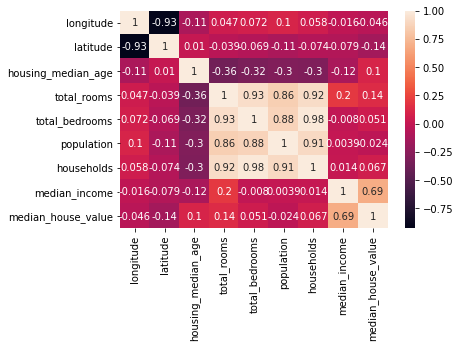

In [ ]:
sns.heatmap(df.corr(), annot = True)
plt.show()

variables depend more on each other if the correlation values are less than -0.5 or greater than 0.5 . hence we see that median_income has the most effect on median_house_value (0.67) and so is the reason of plotting our predicted values and true values against it.

In [ ]:
def distplot(var , n):  
  plt.figure(figsize=(10,10))
  if (n % 2 == 0):
    sns.distplot(var, color='blue') #predicted values in blue colour
  else:
    sns.distplot(var,color='red')  #actual values in red colour
 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



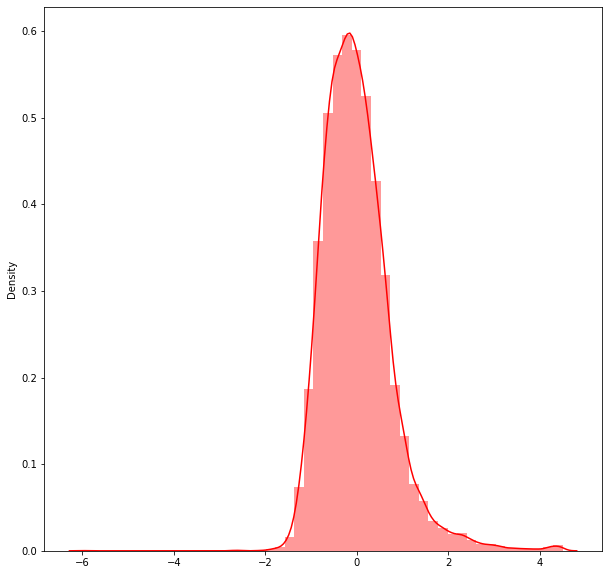

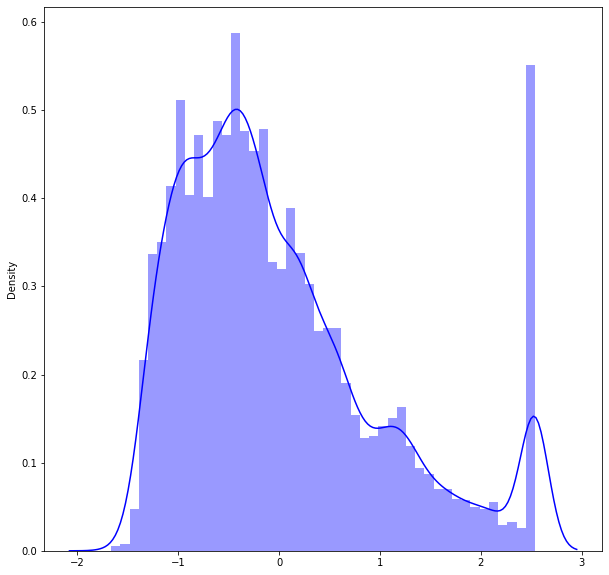

In [ ]:
distplot(y_pred, 1)
distplot(y_true, 2)

distplot is basically a histogram which shows the density of the predicted values in comparision with the actual values, as we see most of our actual data lies between -2 and +2, 
  so is the case with our predicted data and hence we can infer that our predicted values are close enough to the actual ones.

# Part II - Neural Networks 

### Reading the data from CSV and storing in a dataframe

In [ ]:
df = pd.read_csv('housing_data.csv')
assert df.shape == (20000,11)

### Dropping columns having irrelevant/NaN data in them

In [ ]:
df.dropna(axis=1, inplace = True)
assert df.shape == (20000,9)

### Scaling the dataset

In [ ]:
scaler= MinMaxScaler()
scaler.fit(df)
scaled_values = scaler.transform(df)
scaled_df = pd.DataFrame(scaled_values, columns=df.columns)
scaled_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,1.000000,0.175345,0.274510,0.147885,0.198945,0.028364,0.077454,0.068530,0.107012
1,0.984064,0.197662,0.352941,0.201608,0.294848,0.031559,0.075974,0.091040,0.134228
2,0.975100,0.122210,0.313725,0.018927,0.026847,0.009249,0.019076,0.079378,0.145775
3,0.974104,0.116897,0.254902,0.039515,0.052142,0.014350,0.037000,0.185639,0.120414
4,0.974104,0.109458,0.372549,0.038276,0.050435,0.017405,0.042921,0.098281,0.104125


## An overview of our model
The image below shows the structure of the Neural Network we will be building in this assignment. The layers are labeled and the number of neurons for that particular layer are mentioned below them in parentheses.

![NN_4_layer_final.jpg]( 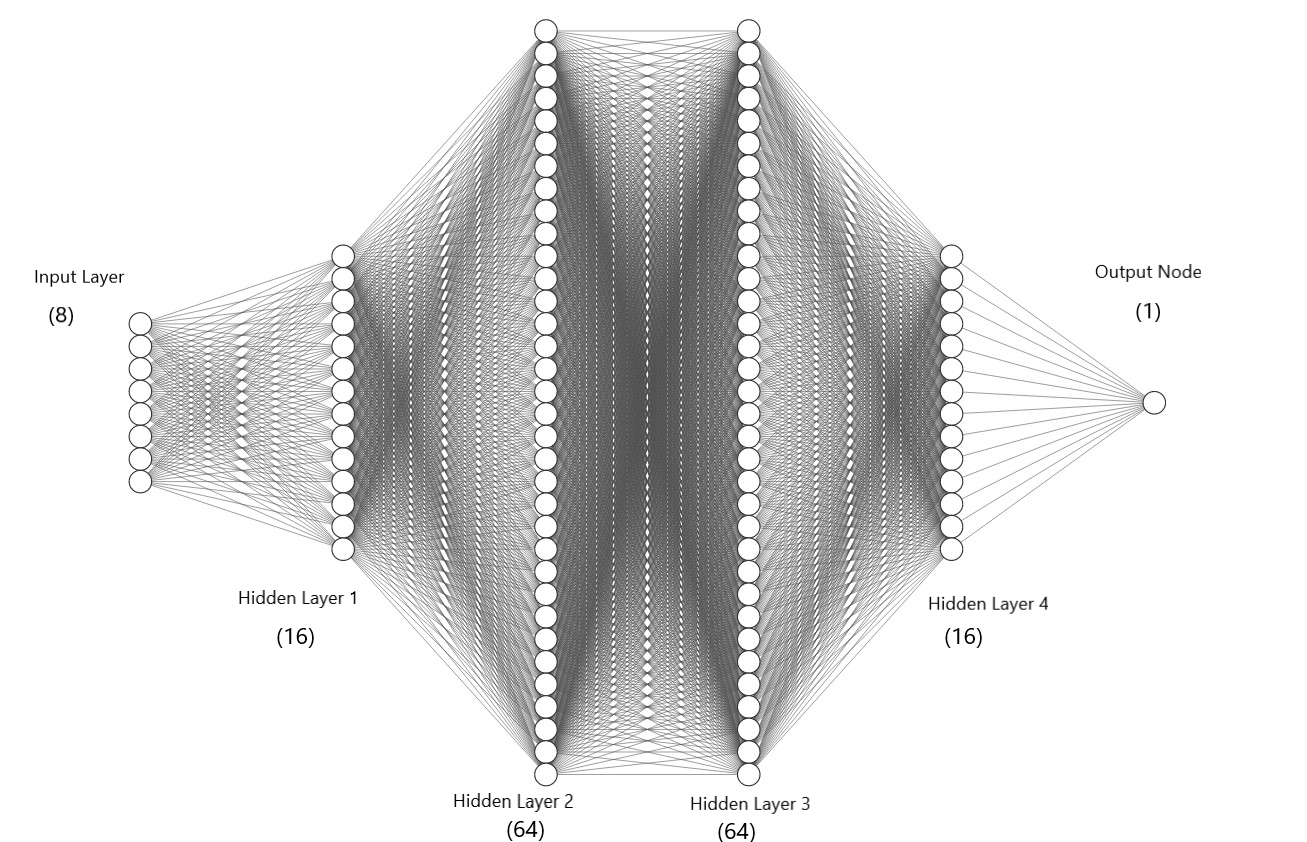)

> **Note**: The number of neurons in the diagram is different than the actual number given below them in parantheses for representation purposes. The number written is the actual number of neurons you will use for your architecture

## Architecture:

In the subsequent cells we will be implementing a **five-layer fully-connected neural network**. The network has an input dimension of I, four hidden layers dimensions of H1, H2, H3, and H4 and performs regression. Hence the output layer will consist of 1 neuron.

We train the network with Mean Squraed Error loss function and L2 regularization on the weight matrices. The network uses a ReLU nonlinearity in between the hidden layers and after the output layer.

In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - ReLU - fully connected layer -ReLU - fully connected layer -ReLU - fully connected layer -RelU

The outputs of the fifth fully-connected layer give us the result

## Terminologies used for describing the computations of the Neural Network:
* Superscript $[h]$ denotes a quantity associated with the $h^{th}$ layer. 
    - Example: $a^{[h]}$ is the $h^{th}$ layer activation. $W^{[h]}$ and $b^{[h]}$ are the $h^{th}$ layer parameters.
* Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $y^{(i)}$ is the ground truth label corresponding to the $i^{th}$ training example.



* A layer of the neural network consists of:
    - a weight matrix $W^{[h]}$of shape (size of current layer, size of previous layer)
    - a bias vector $b^{[h]} $of shape (size of current layer, 1)
    - an activation function $ g^{[h]} $
* Computation in a layer $h$ of the neural network can be described as follows:
  - Let $a^{[h-1]}$ be the activations of the previous layer or input data (if current layer is first hidden layer), of shape (size of previous layer, number of examples).
  - Let $ z^{[h]} $ be the pre-activation value. Then, $ z^{[h]} $ is computed as :
  $$ z^{[h]} = W^{[h]}.a^{[h-1]}+b^{[h]}$$
  where $ . $ denotes matrix multiplication.
  So, $z^{[h]}$ will be of shape (size of current layer, number of examples).
  - Let $a^{[h]}$ denote post activation value. It is computed as:
  $$ a^{[h]} = g^{[h]}(z^{[h]}) $$
  Note that shape of $a^{[h]}$ is same as that of $a^{[h]}$.
  
  - Also note that $A^{[0]}$ is nothing but $X$, the input data.

This function carries out computations of a single layer of the neural network:
 $$ z^{[h]} = W^{[h]}.a^{[h-1]}+b^{[h]}$$
 $$ a^{[h]} = g^{[h]}(z^{[h]}) $$

## Step 1: Initializing the parameters (weights and biases) [0.75 marks]



In the next function, weights are initialized to random values in the range [0, 0.1) using np.random.rand appropriately and biases are initialized to zero

HINT : Initialise weights using numpy.random.rand which gives numbers between [0,1) and then convert all the numbers in this numpy array from [0,1) to [0,0.1) by dividing by a certain number

In [ ]:
#GRADED - 0.75 MARKS
def Initialization(I, H1, H2, H3, H4, O):
    '''
    Weights are initialized to random values in the range [0, 0.1) using np.random.rand appropriately and
    biases are initialized to zero. The dimensions of the
    parameters as as follows:- 

          W1: First layer weights; has shape (H1, I)
          b1: First layer biases; has shape (H1, 1)
          W2: Second layer weights; has shape (H2, H1)
          b2: Second layer biases; has shape (H2, 1)
          W3: Third layer weights; has shape (H3, H2)
          b3: Third layer biases; has shape (H3, 1)
          W4: Fourth layer weights; has shape (H4,H3)
          b4: Fourth layer biases; has shape (H4, 1)
          W5: Fifth layer weights has shape (O,H4)
          b5: Fifth layer biases; has shape (O,1)

          Inputs:
          - I: The number of features of the input data.
          - H1: The number of neurons in the hidden layer - 1.
          - H2: The number of neurons in the hidden layer - 2.
          - H3: The number of neurons in the hidden layer - 3.
          - H4: The number of neurons in the hidden layer - 4.
          - O: The number of outputs(i.e. 1).

          Outputs:
          - paramters_final: List containing of parameters 
          after they are initialized with appropriate values in this order:
          [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 ]
        '''
    W1 = np.random.rand(H1, I)/10.0
    b1 = np.zeros([H1, 1])
    W2 = np.random.rand(H2, H1)/10.0
    b2 = np.zeros([H2, 1])
    W3 = np.random.rand(H3, H2)/10.0
    b3 = np.zeros([H3, 1])
    W4 = np.random.rand(H4, H3)/10.0
    b4 = np.zeros([H4, 1])
    W5 = np.random.rand(O, H4)/10.0
    b5 = np.zeros([O, 1])
    return [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 ]
    
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
#Sample test case
np.random.seed(2)
tln = Initialization(2, 3, 2, 1, 1, 1)
assert tln[0].shape == (3, 2)
assert tln[1].shape == (3, 1)
assert tln[2].shape == (2, 3)
assert tln[3].shape == (2, 1)
assert tln[4].shape == (1, 2)
assert tln[5].shape == (1, 1)
assert tln[6].shape == (1, 1)
assert tln[7].shape == (1, 1)
assert tln[8].shape == (1, 1)
assert tln[9].shape == (1, 1)
assert np.allclose(tln[0][0][0],0.04359949021420038)
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

> Similarly add 2 cells after every function so that after every cell containg a FUNCTION, there are 2 cells after that containing test cases for that particular function 

## Step 2: Implement the activation function [0.25 marks]

Activation functions used:

$$relu(z) = max(0, z)$$

In [ ]:
#GRADED - 0.25 MARKS
def relu(x):
    x [x < 0] = 0
    # YOUR CODE HERE
    return x
    raise NotImplementedError()

In [ ]:
# sample test case
assert np.allclose(relu(np.array([[3,-4]])), np.array([[3,0]]))
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

## Step 3: Forward propagation [0.75 marks]

In [ ]:
#GRADED - 0.75 MARKS
def feed_forward(X, params):
    '''
    Using the formulae given below, apply forward propagation for each layer according to the defined architecture

    z = wX + b
    a = g(z)  {g being the non linear function i.e the activation function}

    Inputs:
    - X : Input data of shape (8, total_number_of_rows). Each X[i] is a feature and each X[:][i] is a training sample
    - params: List containing the parameters of the model

    Outputs:
    - y_out : predicted price
    - l : List containing the activation and linear outputs of each layer in the following fashion
      [z1,a1,z2,a2,z3,a3,z4,a4,z5,a5]
    '''
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = params
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)

    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)

    z3 = np.dot(W3, a2) + b3
    a3 = relu(z3)

    z4 = np.dot(W4, a3) + b4
    a4 = relu(z4)

    z5 = np.dot(W5, a4) + b5
    y_out = relu(z5)
    
    return y_out, [z1, a1, z2, a2, z3, a3, z4, a4, z5, y_out]
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
np.random.seed(2)
para = Initialization(6, 3, 2, 2, 1, 1)
y_forward,l = feed_forward(np.random.rand(6,10), para)
assert y_forward.shape == (1, 10)
assert np.allclose(y_forward[0][5], 1.2063488250870311e-06)
assert l[0].shape==(3,10)
assert l[2].shape==(2,10)
assert l[6].shape==(1,10)
assert np.allclose(l[0][0][1], 0.11645815161695633)
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

## Step 4: Calculating the loss [0.5 marks]

(*Loss*) $L = \frac{1}{2m} * \sum({yd -y\_pred})^{2} $ <br>

where $yd$ is the desired value of y i.e. the one present in our set whereas $y\_pred$ is the value of target we have predicted, and m is the no of examples. <br>


In [ ]:
# GRADED - 0.5 Marks
def loss_compute(y_pred, yd):
    '''
    Inputs: 
    - y_pred: numpy array containing predicted values of target
    - yd: numpy array containing desired values of y given in the 
    dataset

    Outputs:
    - loss: Calculate and return the loss using the above formula
    '''
    loss = (np.sum((y_pred - yd)*(y_pred - yd)))/(2*y_pred.shape[1])
    return loss
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# TEST CASE 1

sample_loss = loss_compute(np.array([[1,1]]) , np.array([[1,0]]))
assert np.allclose(sample_loss,0.25)
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

## Step 5: Regularization [0.5 marks]
It is a technique that discourages learning a more complex or flexible model, so as to avoid the risk of overfitting. It improves the generalization capability of a model, i.e. its performance on unseen test examples.

**Step 5: A function to add regularization by sum of squares so as to prevent overfitting the data**




$$J_{regularized} =  \underbrace{\frac{1}{2m}\sum_{i=1}^{m} (y^{(i)}-a^{[L](i)})^{2}}_{\text{Mean Squared Cost}} +\underbrace{\frac{1}{m}\frac{\lambda}{2}\sum_{l}\sum_{k}\sum_{j}W_{k.j}^{[l]2}}_{\text{L2 regularization cost}}$$

where (k, j) refer to the shape of that pariculat W (weight matrix) and $ l $ refers to the layer number.


You have already implemented Mean Squared Cost function in the last cell. Now in the function below, you'll implement the L2 regularization cost using the formula given

HINT : Try to see what the two inner summations $ \sum_{k}\sum_{j} $ of a particular weight matrix(or any random matrix) looks like. The code for the double summation summed over all layers of our Network, is much much easier than the formula

In [ ]:
#GRADED - 0.5 MARKS
def regularization_L2(lmbda, W1, W2, W3, W4, W5, m):
    '''
    Inputs:
    - lmbda: Regularization parameter
    - W1, W2, W3, W4, W5: numpy arrays containing weights of the model
    - m: no of examples

    Outputs:
    - total_reg_loss: sum of L2 regularization loss of each layer
    '''
    temp = [W1, W2, W3, W4, W5]
    sum = 0
    for i in temp:
        sum = sum + (np.sum(np.square(i)))
    return ((lmbda)/(2*m))*sum 
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# TEST CASE 1

assert np.allclose(regularization_L2(1,np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[1]]),1),2.5)
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

## Step 6: Making helper functions for backpropagation [1.25 marks]
Our next step will be to create some helper functions before starting
backpropagation


### Helper Function 1 [0.25 marks]

We would need derivatives of  the **ReLU** function.

Hint: ReLU function derivative can be calculated in one step using lambda functions. For more information, refer to this link: https://www.w3schools.com/python/python_lambda.asp


Note the following rules for the activation function:
$$ \frac{\partial \mathcal{(relu(z))} }{\partial z} =   \left\{
\begin{array}{ll}
      1 & z>=0 \\
      0& z < 0 \\
\end{array} 
\right. $$

Note: 
The function relu(z) can be written as A(z) where A stands for activation function.

$$ \frac{\partial \mathcal{(relu(z))} }{\partial z} = \frac{\partial \mathcal{A(z)} }{\partial z} $$ 

In [ ]:
#GRADED - 0.25 MARKS
#DERIVATIVE OF RELU
def drelu(x):
    
    # YOUR CODE HERE
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

In [ ]:
# TEST CASE
assert np.allclose(drelu(np.array([[2,-3]])), np.array([[1,0]]))
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

### Helper Function 2 [0.75 marks]

Here, We would be creating a helper function to calculate and return the values of dz, dW, and db for each layer. Refer to the formulae provided below to get a clear understanding of it's implementation.

Note that the value of **dz depends on the derivatives of activation functions** used for that layer and the functions that we have created above may come in handy.

This function computes  $dZ^{[h]} = \frac{\partial \mathcal{L} }{\partial Z^{[h]}}$, given  $dA^{[h]} = \frac{\partial \mathcal{L} }{\partial A^{[h]}}$ and $Z^{[h]}$as inputs. It is based on the following chain rule from calculus:


$$ dZ^{[h]} = \frac{\partial \mathcal{L} }{\partial A^{[h]}} * \frac{\partial \mathcal{A^{[h]}} }{\partial Z^{[h]}}$$

$$ dZ^{[h]} = dA^{[h]} * \frac{\partial \mathcal{A^{[h]}} }{\partial Z^{[h]}}$$



  - $ dW^{[h]} = \frac{\partial \mathcal{L} }{\partial W^{[h]}} = \frac{1}{m} dZ^{[h]} A^{[h-1] T}$
  - $ db^{[h]} = \frac{\partial \mathcal{L} }{\partial b^{[h]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[h](i)}$
  - $ dW_{total}^{[h]} = dW^{[h]} + dW_{reg}^{[h]} $

where $ dW_{reg}^{[h]} = \frac{1}{m} * lambda * weight^{[h]} $ 

The reason we are calculating $ dW^{[h]} $ and $ db^{[h]} $ is they are the ***learnable parameters*** of our model. 

$ dW^{[h]} = \frac{\partial \mathcal{L} }{\partial W^{[h]}} $ signifies the contribution of $ W^{[h]} $ to our loss function $ \mathcal{L} $.
This gradients $ dW^{[h]} $ and $ db^{[h]} $ will help us perform Gradient Descent on our parameters $ W^{[h]} $ and $ b^{[h]} $

If you want to understand more about derivation of above formulas or just about backpropogation in general, look through these slides once : https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec06.pdf
<br />
<br />

 **NOTE** 
: Try to use vectorization as far as possible instead of loops as it would be simpler for you to debug

In [ ]:
# GRADED - 0.75 Marks

def back_prop_linear(da_layer, z_layer, inp, act_fxn, m, lmbda, weight):
    '''
    Inputs:
    - da_layer: derivative of variable 'a' of that layer
    - z_layer: numpy array of 'z' values
    
    - inp: input value of that layer, for example, X is the
    input for the first layer, and for other layers, it is the activation A of the previous layer
    
    - act_fxn: string containing the name of the activation 
    function used in that layer,i.e. 'sigmoid' or 'relu' (depending on this, the appropriate function is called)
    
    - m: number of datapoints
    - lmbda: regularization parameter
    - weight: weights of that particular layer
  
      Outputs:
    - dz: returns the derivative of linear function variable
    - dW: returns the change in weights for that layer
    - db: returns the change in bias for that layer
    '''

    # YOUR CODE HERE
    if(act_fxn is 'relu'):
        dz = da_layer*(drelu(z_layer))
    else:
        print("Invalid Function")
        
    
    dW = (1./m)*(np.dot(dz, inp.T))
    dW_reg = (1./m) * weight * lmbda
    dW_total = dW + dW_reg
    
    db = (1./m)*(np.sum(dz, axis=1, keepdims=True))
    
    return dz, dW_total, db
    raise NotImplementedError()

In [ ]:
# TEST CASE

m=1
# previous layer has 2 neurons and current layer has 2 neurons
z_h=np.array([[1],[2]])
da_h=np.array([[0.1],[0.2]])
inp=np.array([[1],[0]])
weights=np.array([[1,1],[2,0]])
dz, dW, db = back_prop_linear(da_h, z_h, inp, 'relu' , m, 1, weights)
assert np.allclose(dz,np.array([[0.1],[0.2]]))
assert np.allclose(dW,np.array([[1.1,1],[2.2,0]]))
assert np.allclose(db,np.array([[0.1],[0.2]]))
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

### Helper Function 3 [0.25 marks]

We would need a helper function to calculate the derivatives of activation function variables

We will calculate dA for the last layer separately in the subsequent function.

For all other layers, we proceed as follows : 



Using this formula

  - $ Z^{[h]} = W^{[h]}.A^{[h-1]}+b^{[h]}$


  - $ dA^{[h-1]} = \frac{\partial \mathcal{L} }{\partial A^{[h-1]}} = W^{[h] T} dZ^{[h]}$

In [ ]:
# GRADED - 0.25 Marks

def back_prop_actf(W_plusone, dz_plusone):
    '''
    Inputs:
    - W_plusone: Weights of the next layer
    - dz_plusone: Derivative of the linear function of the next
    layer

    Outputs:
    - act_dtive: returns the derivative of activation function variable
    '''
    
    # YOUR CODE HERE
    act_der = np.dot(W_plusone.T, dz_plusone)
    return act_der
    raise NotImplementedError()

In [ ]:
# TEST CASE

# next layer has 2 neurons and current layer has 1, training samples=1
der=back_prop_actf(np.array([[1],[2]]), np.array([[2],[3]]))
assert np.allclose(der,np.array([[8]]))
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

## Combining all the helper functions for Backpropogation [1.5 marks]

Now we will be creating the main function for backpropagation where we combine all the helper functions to update the weights. We will first compute errors at the last layer and backpropagate them through the network to get the desired $dW$ and $db$ for each layer.

We would using a single function to return these values as the formula remains the same.

To backpropagate through this network, we know that the output is, $ ypred = A^{[H]} = ReLU(Z^{[H]})$. Your code thus needs to compute $ dA^{[H]} = \frac{\partial \mathcal{L}}{\partial A^{[H]}}$. To do so, use this formula:
$$ dA^{[H]} = -({yd -A^{[H]}})$$

**Remember: This is only for the last layer, use the above helper function for the other layers.**

**HINT:** Use the back_prop_linear function to obtain $dz,dW,db$ at each layer.

So to sum up all the Backpropogation helper functions and combine them in the next function : 

Calculate $ dA^{[H]} = \frac{\partial \mathcal{L}}{\partial A^{[H]}}$ for the **last layer** using the forumula:
$$ dA^{[H]} = -({yd -A^{[H]}})$$

After that , calculate  $ dW^{[H]}$ ,  $db^{[H]}$ and  $ dz^{[H]} $ using back_prop_linear function.

HINT : You already have $ dA^{[5]} $ using the formula given above. From that you can calculate $ dW^{[5]}$ ,  $db^{[5]}$ and  $ dz^{[5]} $ using back_prop_linear function

Now use back_prop_actf to find $ dA^{[4]} $ followed by back_prop_linear to find $ dW^{[4]}$ ,  $db^{[4]}$ and  $ dz^{[4]} $

Continue this process till you have the gradients for all 5 Weights and Biases

In [ ]:
# GRADED - 1.25 Marks

def Backpropagation1(X, yd, l, y_pred, parameters, lmbda):
    '''
      Inputs:
      - X: Input features - shape (no of features, no of examples)
      - yd: y desired values(labels given in dataset)
      - l: list containing values of 'z' and 'a' of each layer
      - parameters: list containing weights and biases of each layer
      - lmbda: regularization parameter

      Outputs:
      - grad: dictionary containing the change in the values of weights
      and biases with keys 'dW1','db1','dW2','db2','dW3','db3' 
    '''
    
    # YOUR CODE HERE
    grads = {}
    z1, a1, z2, a2, z3, a3, z4, a4, z5, a5 = l
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = parameters
    m = X.shape[1]
    
    dA5 = - (yd - y_pred)
    dz5, grads['dW5'], grads['db5'] = back_prop_linear(dA5, z5, a4, 'relu', m, lmbda, W5)
    
    dA4 = back_prop_actf(W5, dz5)
    dz4, grads['dW4'], grads['db4'] = back_prop_linear(dA4, z4, a3, 'relu', m, lmbda, W4)

    dA3 = back_prop_actf(W4, dz4)
    dz3, grads['dW3'], grads['db3'] = back_prop_linear(dA3, z3, a2, 'relu', m, lmbda, W3)

    dA2 = back_prop_actf(W3, dz3)
    dz2, grads['dW2'], grads['db2'] = back_prop_linear(dA2, z2, a1, 'relu', m, lmbda, W2)
    
    dA1 = back_prop_actf(W2, dz2)
    dz1, grads['dW1'], grads['db1'] = back_prop_linear(dA1, z1, X, 'relu', m, lmbda, W1)

    return grads
    raise NotImplementedError()

In [ ]:
grads_check = {'dW1' : np.array([0.00477814 ,0.00262214]),
               'dW2' : np.array([0.00338872 ,0.00096401]),
               'dW3' : np.array([0.00384367 ,0.00093328 ,0.00427237]),
               'dW4' : np.array([0.00477098 ,0.00216877 ,0.00474162]),
               'dW5' : np.array([0.00010706 ,0.00272906]),
               'db1': np.array([-5.70127772e-05]),
               'db2': np.array([-0.00048472]),
               'db3': np.array([-0.00272006]),
               'db4': np.array([-0.00374705]),
               'db5': np.array([-0.4999496])
              }
np.random.seed(4)
parameters = Initialization(2, 2, 3, 3, 2, 1)
X = np.array([[1,2],[2,3]])
y_pred, l = feed_forward(X, parameters)
sample_grads = Backpropagation1(X, np.array([[1,0]]), l, y_pred, parameters, lmbda = 0.1)
for key in grads_check.keys():
    assert np.allclose(grads_check[key],sample_grads[key][0])
print('Sample Test passed', '\U0001F44D')

Sample Test passed 👍


In [ ]:
# hidden test cases. Do not modify

The weights are now updated in each iteration via the learning rules:

$$ W^{[h]} = W^{[h]} - \alpha \text{ } dW^{[h]} $$
$$ b^{[h]} = b^{[h]} - \alpha \text{ } db^{[h]} $$

where h takes value from 1 to 5 for our 4 hidden layers and 1 output node
<br />
<br />

- We are done with most of the code now, yet there is the most important function left to be created - where we will be training our model.

- Refer to the overview again before writing a code for this function.

- You will have to call the above functions repeatedly and update the weights and bias with each iteration

- The values of number of iterations(num_iters), learning rate(eta) and regularization parameter(lmbda) **have been already tuned**. If you wish to experiment on these variables for a better understanding, you are free to do so. The final result, however, will be evaluated using the values given.

## Training your model [1.5 marks]

For training the model you need to do the following in the next function:
1) You are provided with *X, yd, parameters* as arguments. *X* and *yd* are scaled so **DO NOT** scale them again inside this *training* function 

2) Store W1 to W5 and b1 to b5 (weights and biases) in **seperate variables** by accessing the *parameters* argument

3) Initialise an empty list to which you will append the loss of every iteration

4) Now for N number of iterations:
     - compute y_predicted and a5 using feedforward
     
     - compute loss using y_predicted and yd - say loss_1
     
     - calculate regularization loss say loss_2
     
     - total loss = loss_1 + loss_2
     
     - append this to the list you created in step 3
     
     - calculate gradients
     
     - update W1 to W5 and b1 to b5 by using the gradients calculated above
     
     - in the next iteration , when using feed forward use these updated W1 to W5 and b1 to  b5
     
     - And then follow this for N iterations
     
5) Return the history of loss (that list you created in step 3 populated with loss of every iteration) and the trained *W* and *b*

In [ ]:
#GRADED - 1.5 MARKS
def training(X, yd, parameters, eta = 0.05, num_iters=3000, lmbda = 0.1):
    '''
      Inputs:
      - X: Input features - shape (no of features, no of examples) 
      - yd: y desired values of shape (1,no. of examples)
      - parameters - The initial parameters of the model (W and b) in the same format as they were returned by the 
          Initialization function ie. [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 ]
      - eta: learning rate
      - num_iters: number of iterations
      - lmbda: regularization parameter

      Outputs:
      - losses: list of loss at the start of each iteration 
      - parameters: the final TRAINED parameters
      Return in the format : losses,[W1,b1,W2,b2,W3,b3,W4,b4,W5,b5]
    '''
    m = X.shape[1]
    history = []
    
    for i in range(num_iters):
        # forward prop
        y_pred, cache = feed_forward(X, parameters)
        
        W1, W2, W3, W4, W5 = parameters[::2]

        # loss compute + backprop
        loss = loss_compute(y_pred, yd) + regularization_L2(lmbda, W1, W2, W3, W4, W5, m)
        grads = Backpropagation1(X, yd, cache, y_pred, parameters, lmbda)

        # param update
        parameters[0] -= eta*grads['dW1']
        parameters[1] -= eta*grads['db1']
        parameters[2] -= eta*grads['dW2']
        parameters[3] -= eta*grads['db2']
        parameters[4] -= eta*grads['dW3']
        parameters[5] -= eta*grads['db3']
        parameters[6] -= eta*grads['dW4']
        parameters[7] -= eta*grads['db4']
        parameters[8] -= eta*grads['dW5']
        parameters[9] -= eta*grads['db5']
        
        # if(i%50 == 0):
        # print("Loss after " + str(i+1) + " iterations is " + str(loss))
        
        history.append(loss)
    
    return history, parameters
    # YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
#See the starting of Neural Network section where we decclared the scaled_df dataframe 
X_df = scaled_df.iloc[:,0:8] # The first 8 columns are our X variables
Y_df = scaled_df.iloc[:,8:9] # The 9th column or 'median_house_value' is what we are trying to predict
x_train  = X_df.values.T
y_actual = Y_df.values.reshape(1,-1)

In [ ]:
losses[200]

0.2881198530198049

In [ ]:
#Sample test case
np.random.seed(2)
parameters = Initialization(8,16,64,64,16,1) #ALL ACTIVATION RELU
losses, parameters_final = training(x_train, y_actual,parameters, eta = 0.05, num_iters=300, lmbda = 0.1) 
assert np.allclose(losses[200],0.018760000609514545)
print('Sample Test passed', '\U0001F44D')
#You can change num_iters to 10000, will take around 10-15 minutes to train
'''
You can also play around with the model hyper-parameters to see if you can improve on our results
Try changing:
    - The model architecture (number of layers, number of neurons in each layer)
    - The batch size
    - The learning rate
    
Make sure you set the parameters to their original values before submitting the assignment
'''

Sample Test passed 👍


'\nYou can also play around with the model hyper-parameters to see if you can improve on our results\nTry changing:\n    - The model architecture (number of layers, number of neurons in each layer)\n    - The batch size\n    - The learning rate\n    \nMake sure you set the parameters to their original values before submitting the assignment\n'

In [ ]:
# hidden test cases. Do not modify

To self-evaluate the result obtained, plot the loss function with respect to the number of iterations and rethink the algorithm if your loss function is not reaching a minimum value.

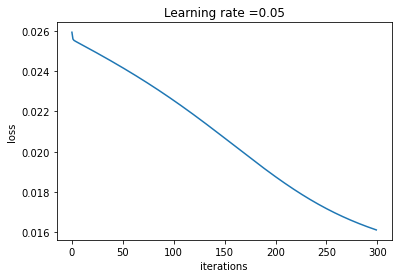

In [ ]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.05))
plt.show()

> If everything goes well, the above loss plot should be reaching 0.012 - 0.010 after around 3k-4k epochs 

In [ ]:
#Let's see how well our model works on TEST data
df_test  = pd.read_csv('california_housing_test.csv')
scaler = MinMaxScaler()
scaler.fit(df)
test_scaled_data = scaler.transform(df_test)
test_scaled_df = pd.DataFrame(test_scaled_data,columns=df_test.columns) #make sure column names are retained

xtest = test_scaled_df.iloc[:,0:8] 
ytest = test_scaled_df.iloc[:,8:9]
xtest  = xtest.values.T
ytest = ytest.values.reshape(1,-1)

ytest_pred = feed_forward(xtest,parameters_final)[0]
print(mean_squared_error(ytest,ytest_pred))

0.031460560985035003


On the test set  : 

MSE of Linear model was approximately 0.10

MSE of Neural Network is approximately 0.03

> The mean square error has reduced by a factor of around 3 and that too with a very simple neural network architecture. If we were to use dropout, batch size, better optimizers and so on, we could have gotten even better results.

# Part III - Implementing Particle Swarm Optimization

## Defining the fitness function [ungraded]
The [Ackley function](https://en.wikipedia.org/wiki/Ackley_function) is commonly used as a performance test problem for various optimization algorithms. We have provided the definition, code as well as a visualization for it. 

Definition: 

\begin{aligned}
f(x,y)=20&\exp \left[-0.2{\sqrt {0.5\left(x^{2}+y^{2}\right)}}\right]+\exp \left[0.5\left(\cos 2\pi x+\cos 2\pi y\right)\right]-e-20
\end{aligned}

In [ ]:
def fitness(pos, a=20, b=0.2, c=2*np.pi):
    x,y = pos
    term_1 = np.exp((-b * np.sqrt(0.5 * (x ** 2 + y ** 2))))
    term_2 = np.exp((np.cos(c * x) + np.cos(c * y)) / 2)
    return a * term_1 + term_2 - a - np.exp(1)

## Visualizing the fitness function [ungraded]
Run the cell below to see an interactive 3-d plot of the Ackley function.

You can see why it is used as a test function for optimization algorithms - it has a lot of local maxima and it is relatively difficult to reach the global optimum located at (0,0)


In [ ]:
@np.vectorize # What does this line do, why is it useful?
def visualize_cost(x, y, a=20, b=0.2, c=2*np.pi):
    term_1 = np.exp((-b * np.sqrt(0.5 * (x ** 2 + y ** 2))))
    term_2 = np.exp((np.cos(c * x) + np.cos(c * y)) / 2)
    return a * term_1 + term_2 - a - np.exp(1)

lo, hi = -7,7
x = np.linspace(lo, hi, 200)
y = np.linspace(lo, hi, 200)
xGrid, yGrid = np.meshgrid(x, y)

x = xGrid
y = yGrid
z = visualize_cost(xGrid, yGrid)

surface = go.Surface(x=x, y=y, z=z)
data = [surface]

layout = go.Layout(
    title='The Ackley function',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

## Task 1 - Defining a particle [0.75 marks]
Define a particle as a class. We have already implemented the class for you, all you need to do is implement the `__init__()` function.

The particle takes its initial position (x,y) along with its initial velocity (vx,vy) as an input.  
Define the `self.pos`, `self.vel` and `self.best_pos` for the particle's postion, velocity and best position repsectively

> **NOTE**: Define the particles position, velocity and best_position as numpy arrays of size (2,).


In [ ]:
#GRADED - 0.75 MARKS
# Defining a particle
class Particle():
    ''' A single partice, part of a swarm for PSO '''
    
    def __init__(self, x, y, vx, vy): # Task 1
        ''' initialize the particle'''
        self.pos = np.array([x, y])
        self.vel = np.array([vx, vy])
        self.best_pos = np.array([x, y])
        # YOUR CODE HERE
        #raise NotImplementedError()
    
    def __str__(self):
        ''' Controls how a particle is printed '''
        return f'Particle: pos: {self.pos}, velocity: {self.vel} fitness: {fitness(self.pos)}'
    
    def __repr__(self):
        ''' Controls how a particle is printed as a part of a list'''
        return f'Particle: pos: {self.pos}, velocity: {self.vel} fitness: {fitness(self.pos)}'        

In [ ]:
#Sample Test Cases
p1 = Particle(x=5,y=4,vx=0.1, vy=0.01)

assert np.array_equal(p1.pos, np.array([5,4])), f'Postion {p1.pos} is not equal to [5 5]'
assert np.array_equal(p1.vel, np.array([0.1,0.01])), f'Velocity {p1.vel} is not equal to [0.1 0.01]'
assert np.isclose(fitness(p1.pos), -11.913518152857637), f'fitness {fitness(p1.pos)} is not equal to -11.913518152857637'

print("Sample test cases passed successfully!!")

Sample test cases passed successfully!!


In [ ]:
# hidden test cases. Do not modify

## Task 2 - Create a swarm of particles [0.75 marks]

A swarm is the group of particles. Every particle in each swarm affects the position and the velocity of every other particle in the swarm. 

The number of particles and their position / velocity ranges are given to you as hyper parameters. Initialize the swarm by assigning random positions and velocities to each particle in the swarm.
> **NOTE**: Use the [np.random.random](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.random.html) function to generate the required random numbers. 

> You need to generate 4 random numbers for x, y, vx and vy 


In [ ]:
#GRADED - 0.75 MARKS
def initialize_swarm(hyper_params): # task 2
    '''
    Initialize a swarm of particles using the Particle class
    '''
    
    particles = []
    p_lo, p_hi = hyper_params['pos_range']
    v_lo, v_hi = hyper_params['vel_range']

    for i in range(hyper_params['pop_size']):
        pos_x = np.random.random()*(p_hi - p_lo) + p_lo
        pos_y = np.random.random()*(p_hi - p_lo) + p_lo
        vel_x = np.random.random()*(v_hi - v_lo) + v_lo
        vel_y = np.random.random()*(v_hi - v_lo) + v_lo
        particle = Particle(x = pos_x, y = pos_y, vx = vel_x, vy = vel_y)
        particles.append(particle)
        # Create a particle with random position and random velocity and add it to the particles array
        # YOUR CODE HERE
        #raise NotImplementedError()
        
    best_particle = max(particles, key = lambda p: fitness(p.pos)) # Understand what this line does properly, you will need to use something similar later on
    best_pos = best_particle.pos

    return {
        'best_pos': best_pos,
        'population': particles,
    }

In [ ]:
#Sample Test Cases
np.random.seed(42)
hyper_params = {'w': 10, 'c1': 0.1, 'c2': 0.2, 'pos_range': (-7,7), 'vel_range': (-1,1), 'pop_size': 5, 'iterations': 100}
sample_swarm = initialize_swarm(hyper_params)

assert len(sample_swarm['population']) == 5, 'length of swarm is not equal to 5' 
assert np.allclose(sample_swarm['best_pos'], np.array([-2.7406086, 0.34659004])), f'Swarm\'s best position {sample_swarm["best_pos"]} is not equal to [-2.7406086   0.34659004]'
assert np.allclose(sample_swarm['population'][0].pos, np.array([-1.75643834, 6.31000029])), f'First particle\'s position {sample_swarm["population"][0].pos} is not equal to [-1.75643834  6.31000029]'
assert np.allclose(sample_swarm['population'][0].vel, np.array([0.46398788, 0.19731697])), f'First particle\'s velocity {sample_swarm["population"][0].vel} is not equal to [0.46398788 0.19731697]'

print("Sample test cases passed successfully!!")

Sample test cases passed successfully!!


In [ ]:
# hidden test cases. Do not modify

## Task 3 - Update a particles velocity [0.75 marks]

Updating the particle's velocity. Now we know that the new velocity of the particle is influenced by 3 conditions.

1.   local: (random number between 0 and 1) * (particle's best position - particle's current postion) 
2.   global: (random number between 0 and 1) * (swarms's best position - particle's current postion.)
3.   inertia: particle's current velocity.

The overall formula is:  

$
\begin{aligned}
    \textrm{new velocity} = \frac{w \cdot \textrm{inertia} + c_1 \cdot \textrm{local} + c_2 \cdot \textrm{global}}{w + c_1 + c_2} 
\end{aligned}$

In [ ]:
#GRADED - 0.75 MARKS
def update_velocity(hyper_params, swarm, particle, ): # task 3  
    '''
    Update the given particle's velocity
    '''
    w, c1, c2 = hyper_params['w'], hyper_params['c1'], hyper_params['c2']
    local = np.random.random()*(particle.best_pos - particle.pos)
    global_pos = np.random.random()*(swarm['best_pos'] - particle.pos)
    new_vel = (w*particle.vel + c1*local + c2*global_pos)/(w + c1 + c2)
    particle.vel = new_vel
    # lower_bound = hyper_params['vel_range'][0]
    # upper_bound = hyper_params['vel_range'][1]
    # particle.vel [particle.vel < lower_bound] = lower_bound
    # particle.vel [particle.vel > upper_bound] = upper_bound
    
    # YOUR CODE HERE
    #raise NotImplementedError()

In [ ]:
#Sample Test Cases
np.random.seed(42)
hyper_params = {'w': 10, 'c1': 0.1, 'c2': 0.2, 'pos_range': (-7,7), 'vel_range': (-1,1), 'pop_size': 5, 'iterations': 100}
sample_swarm = initialize_swarm(hyper_params)
sample_particle = sample_swarm['population'][0]

update_velocity(hyper_params, sample_swarm, sample_particle)

assert np.allclose(sample_particle.vel, np.array([0.44780793, 0.17541727])), f'particle\'s velocity {sample_swarm["population"][0].vel} is not equal to [0.44780793 0.17541727]'

print("Sample test cases passed successfully!!")

Sample test cases passed successfully!!


In [ ]:
# hidden test cases. Do not modify

## Task 4 - Update a particles position [0.75 marks]

Now you need to implement update_position, which updates the particle's position and it's best position. You can implement it using the definition given below.

new position = old position + new velocity 

> **Note**: The particle's position should be within the lower bounds and the upper bounds defined in the hyperparameters dictionary (lo and hi respectively)

In [ ]:
sample_particle.pos

array([-1.75643834,  6.31000029])

In [ ]:
#GRADED - 0.75 MARKS
def update_position(hyper_params, particle): # task 4
    '''
    Update the given particle's position
    '''
    old_fitness = fitness(particle.best_pos)
    particle.pos = particle.pos + particle.vel
    lower_bound = hyper_params['pos_range'][0]
    upper_bound = hyper_params['pos_range'][1]
    particle.pos [particle.pos < lower_bound] = lower_bound
    particle.pos [particle.pos > upper_bound] = upper_bound
    if (fitness(particle.pos) > old_fitness):
        particle.best_pos = particle.pos
    # YOUR CODE HERE
    #raise NotImplementedError()

In [ ]:
#Sample Test Cases.
np.random.seed(42)
hyper_params = {'w': 10, 'c1': 0.1, 'c2': 0.2, 'pos_range': (-7,7), 'vel_range': (-1,1), 'pop_size': 5, 'iterations': 100}
sample_swarm = initialize_swarm(hyper_params)
sample_particle = sample_swarm['population'][4]
update_position(hyper_params, sample_particle)

assert np.allclose(sample_particle.pos, np.array([-2.87671856, -0.07095168])), f'particle\'s position {sample_particle.pos} is not equal to [-2.87671856 -0.07095168]'
assert np.allclose(sample_particle.best_pos, np.array([-2.87671856, -0.07095168])), f'particle\'s best position {sample_particle.best_pos} is not equal to [-2.87671856 -0.07095168]'
assert np.allclose(sample_particle.vel, np.array([-0.13610996, -0.41754172])), f'particle\'s velocity {sample_particle.vel} is not equal to [-0.13610996 -0.41754172]'
print("Sample test cases passed successfully!!")

Sample test cases passed successfully!!


In [ ]:
# hidden test cases. Do not modify

## Task 5 - Putting it all together [2 marks]

Now it is time to finally implement PSO. 
You will be using all the functions that you had written above.

You need to do the following:
1. initialize a swarm of particles using the `initialize_swarm()` function
2. In every iteration for every swarm particle, update the particle's velocity first using the `update_velocity()` function and then update the particle's position using the `update_position()` function
3. At the end of every iteration update the swarm's best position (stored in `swarm['best_pos']`)


In [ ]:
#GRADED - 2 MARKS
def PSO(hyper_params):
    '''
    Implementing Particle Swarm Optimization 
    '''
    history = []

    swarm = initialize_swarm(hyper_params)
    i = 0
    for _ in range(hyper_params['iterations']):
        # YOUR CODE HERE
        #print("Iteration " + str(i) + "  : ")
        for particle in swarm['population']:
            update_velocity(hyper_params, swarm, particle)
            update_position(hyper_params, particle)
            #print(" Velocity of Particle : " + str(particle.vel))
        for particle in swarm['population']:
            if (fitness(particle.pos) > fitness(swarm['best_pos'])):
                swarm['best_pos'] = particle.pos
            #print(" Best Fitness : " + str(fitness(particle.best_pos)) +  " Current Fitness : " + str(fitness(particle.pos)))
        #print ("Best Fitness of Swarm : " + str(fitness(swarm['best_pos'])))
        # print (" ")
        # i += 1
        # raise NotImplementedError()
        history.append(deepcopy(swarm)) # Do not modify, this is used for visualization
        
    return swarm['best_pos'], history

In [ ]:
#Sample Test Cases
np.random.seed(42)
hyper_params = {'w': 10, 'c1': 0.1, 'c2': 0.2, 'pos_range': (-7,7), 'vel_range': (-1,1), 'pop_size': 5, 'iterations': 100}
optimum, hist = PSO(hyper_params)

assert np.allclose(hist[0]['best_pos'], np.array([-2.87275419, -0.05879027])), f'optimum after 1 iteration {hist[0]["best_pos"]} is not equal to [-2.87275419 -0.05879027]'
assert np.allclose(hist[49]['best_pos'], np.array([ 0.24962491, -0.15234245])), f'optimum after 50 iterations {hist[49]["best_pos"]} is not equal to [ 0.24962491 -0.15234245]'
assert np.allclose(hist[69]['best_pos'], np.array([0.15064717, 0.09838713])), f'optimum after 70 iterations {hist[69]["best_pos"]} is not equal to [0.15064717 0.09838713]'
assert np.allclose(optimum, np.array([ 0.04856536, -0.01389739])), f'optimum after 100 iterations {optimum} is not equal to [ 0.04856536 -0.01389739]'

print("Sample test cases passed successfully!!")

Sample test cases passed successfully!!


In [ ]:
# hidden test cases. Do not modify

## Tuning hyper-parameters [ungraded]

A few hyper-parameters for defining the PSO are provided below.  
Once you are done with the assignment you can try and experiment by changing them.   
(Changing these wont affect the hidden test cases so you can freely play around with these)

In [ ]:
hyper_params = {
    'w': 10, # inertia 
    'c1': 0.1, # local
    'c2': 0.2, # global
    'pos_range': (-7,7), # range in which a PSO particle can move
    'vel_range': (-1,1), # velocity range for a PSO particle
    'pop_size': 5, # Number of particles in the swarm
    'iterations': 100, # Number of iterations
}

optimum, hist = PSO(hyper_params)
print(f'PSO found the optimum at {optimum} with a fitness of {fitness(optimum)}')
print('The global maxima is at [0 0] with a cost of 0')

PSO found the optimum at [ 0.00857147 -0.00662809] with a fitness of -0.03377035272992446
The global maxima is at [0 0] with a cost of 0


## Seeing your PSO in action [ungraded]

- An important part of your ML algorithm is visualizing it to make sure that it is working properly and to get a visual understanding of how well it is performing. 
- We have implemented a simple visualization for the PSO algorithm.
- The (best) fitness of the swarm along with each individual particle (averaged over 20 runs) is displayed on the Y-axis with the number of iterations on the X-axis
- You can see that the swarm's best fitness is always above any individual particle's fitness and also how the fitness slowly improves over time. 

100%|██████████| 100/100 [00:05<00:00, 19.16it/s]


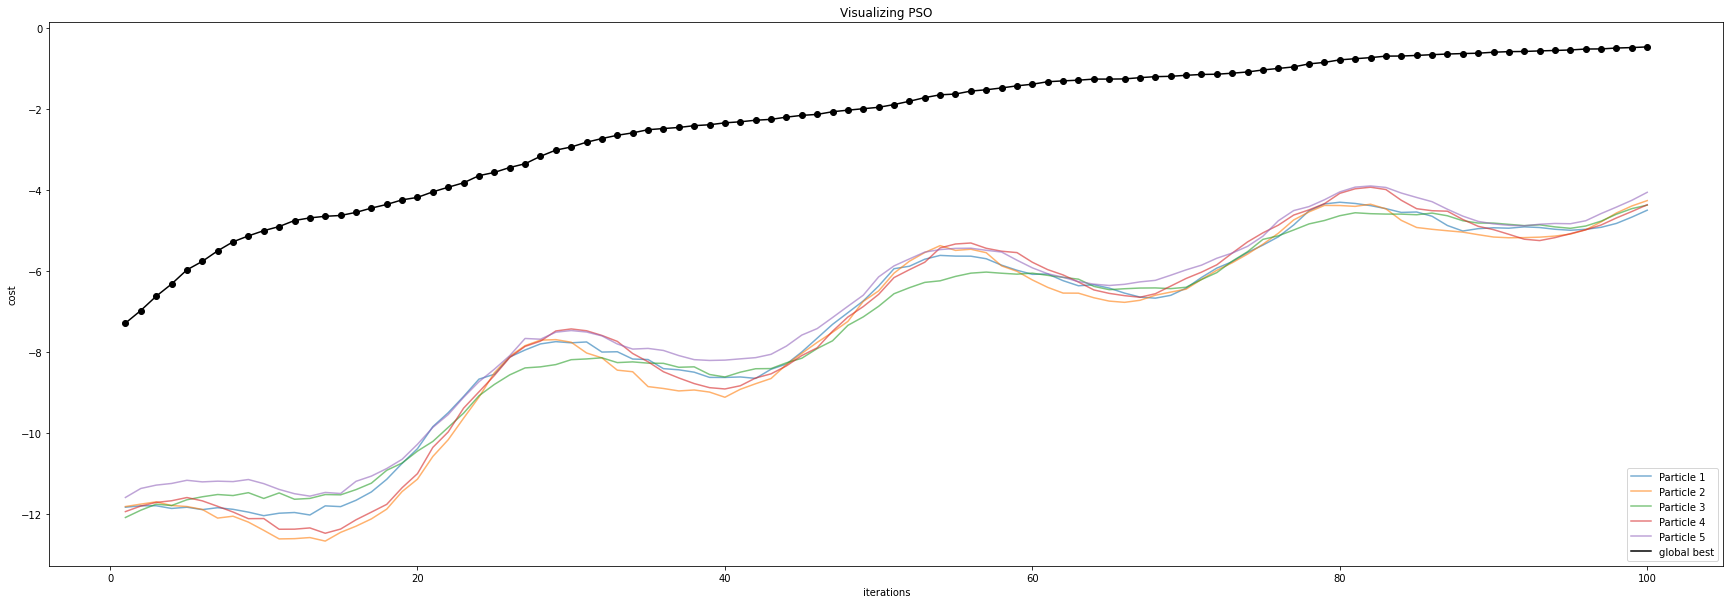

In [ ]:
num_trials = 100 # Run the PSO algorithm 100 times and show the average results

hists = []
for _ in tqdm(range(num_trials)):
    _, hist = PSO(hyper_params)
    hists.append(hist)

global_best = [0]*hyper_params['iterations']
particle_best = [[0]*hyper_params['iterations'] for p in range(hyper_params['pop_size'])]

for hist in hists:
    for i,swarm in enumerate(hist):
        global_best[i] += fitness(swarm['best_pos']) / num_trials
        for j,particle in enumerate(swarm['population']):
            particle_best[j][i] += fitness(particle.pos)/ num_trials
    
plt.rcParams["figure.figsize"] = (30,10)

x = list(range(1, hyper_params['iterations']+1))
for i in range(hyper_params['pop_size']):
    plt.plot(x, particle_best[i], label=f'Particle {i+1}', alpha=0.6)

plt.plot(x, global_best, label='global best', c='k')
plt.scatter(x, global_best, marker='o', c='k')

plt.title('Visualizing PSO')
plt.xlabel('iterations')
plt.ylabel('cost')
plt.legend(loc='lower right')
plt.show()